In [5]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from transformers import AutoImageProcessor, AutoModelForImageClassification
import matplotlib.pyplot as plt


c:\Users\Gebruiker\anaconda3\envs\AML_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Paths to the CSV files
train_csv_path = "C:/Users/Gebruiker/Documents/UVA/Vakken met code/AML/AML2024-Feather-in-Focus/data/train_images.csv"  # Update with the correct path
test_csv_path = "C:/Users/Gebruiker/Documents/UVA/Vakken met code/AML/AML2024-Feather-in-Focus/data/test_images_path.csv"  # Update with the correct path

# Load the data into DataFrames
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

# Inspect the training data
print(train_df.head())
print(f"Number of training samples: {len(train_df)}")
print(f"Number of test samples: {len(test_df)}")


            image_path  label
0  /train_images/1.jpg      1
1  /train_images/2.jpg      1
2  /train_images/3.jpg      1
3  /train_images/4.jpg      1
4  /train_images/5.jpg      1
Number of training samples: 3926
Number of test samples: 4000


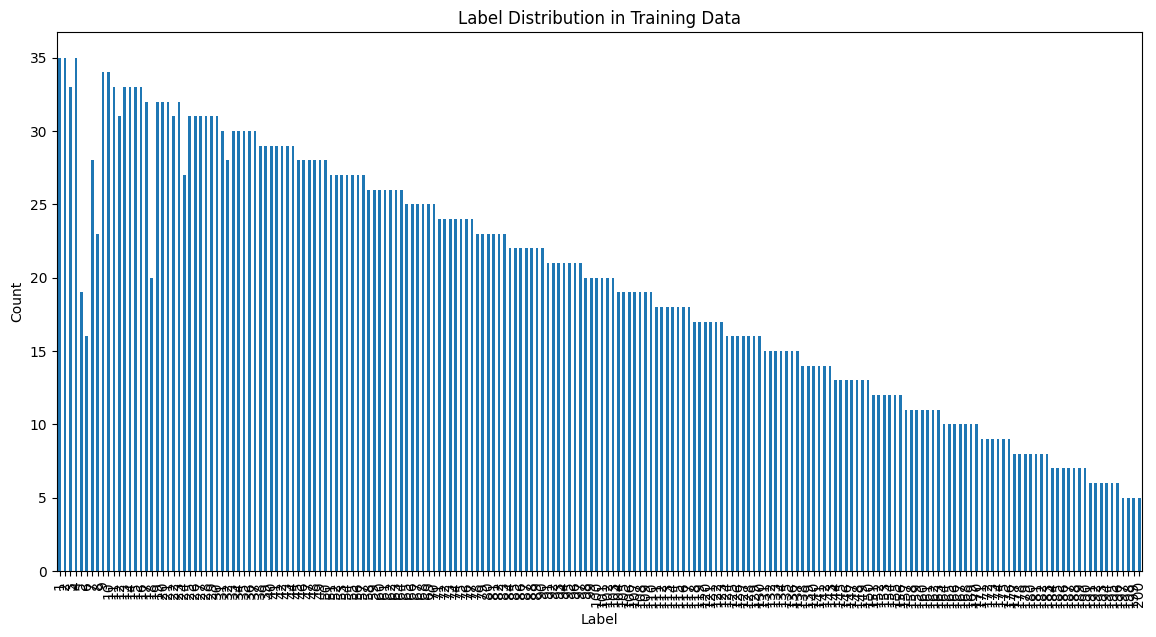

In [7]:
label_counts = train_df['label'].value_counts()
plt.figure(figsize=(14, 7))
label_counts.sort_index().plot(kind='bar')
plt.title('Label Distribution in Training Data')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


In [12]:
class BirdDataset(Dataset):
    def __init__(self, csv_file, img_dir, processor, transform=None, is_test=False):
        """
        Args:
            csv_file (str): Path to the CSV file.
            img_dir (str): Path to the directory containing images.
            processor: Hugging Face AutoImageProcessor for preprocessing.
            transform: Additional PyTorch transformations (optional).
            is_test (bool): Whether this dataset is for testing (no labels).
        """
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.processor = processor
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # img_path = os.path.join(self.img_dir, self.data.iloc[idx, 0])
        img_path = "./images/"+ self.data.iloc[idx, 0]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        # Use Hugging Face processor for preprocessing
        image = self.processor(images=image, return_tensors="pt")["pixel_values"].squeeze(0)

        if self.is_test:
            return image
        else:
            label = self.data.iloc[idx, 1]
            label = torch.tensor(label - 1, dtype=torch.long)  # Subtract 1 for zero-based indexing
            return image, label


In [13]:
from transformers import AutoImageProcessor, AutoModelForImageClassification

# Load pre-trained model and processor
processor = AutoImageProcessor.from_pretrained("chriamue/bird-species-classifier")
model = AutoModelForImageClassification.from_pretrained("chriamue/bird-species-classifier")

# Move model to GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [14]:
# Paths to image directories
train_img_dir = "C:/Users/Gebruiker/Documents/UVA/Vakken met code/AML/AML2024-Feather-in-Focus/data/images/train_images/"
test_img_dir = "C:/Users/Gebruiker/Documents/UVA/Vakken met code/AML/AML2024-Feather-in-Focus/data/images/test_images/"

# Create datasets
train_dataset = BirdDataset(train_csv_path, train_img_dir, processor, is_test=False)
test_dataset = BirdDataset(test_csv_path, test_img_dir, processor, is_test=True)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [16]:
print("Current working directory:", os.getcwd())
# Change the working directory to the folder containing the files
os.chdir("C:/Users/Gebruiker/Documents/UVA/Vakken met code/AML/AML2024-Feather-in-Focus/data")
print("Current working directory:", os.getcwd())

Current working directory: c:\Users\Gebruiker\Documents\UVA\Vakken met code\AML\AML2024-Feather-in-Focus
Current working directory: C:\Users\Gebruiker\Documents\UVA\Vakken met code\AML\AML2024-Feather-in-Focus\data


In [17]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(pixel_values=images)
        loss = criterion(outputs.logits, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


KeyboardInterrupt: 

In [ ]:
model.eval()
predictions = []

with torch.no_grad():
    for images in test_loader:
        images = images.to(device)
        outputs = model(pixel_values=images)
        predicted_class = outputs.logits.argmax(dim=-1).item() + 1  # Add 1 for 1-based indexing
        predictions.append(predicted_class)

# Save predictions to a CSV file
test_df['label'] = predictions
test_df.to_csv("predictions.csv", index=False)
